In [173]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from matplotlib import pyplot as plt

from utils.basic_utils import *
from utils.pricing import *

pd.options.display.float_format = '{:,.2f}'.format

In [393]:
import os, sys
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.validation import column_or_1d
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

In [11]:
bench = '^GSPC'
sec_windows, stds = [5, 20, 60], 1
pred_fwd_windows = [60]
inv = incl_px = incl_name = False
y_col = 'fwdReturn'

In [68]:
cuts = { '1d': [-1, -0.1, -.02, .02, .1, 1.] }
cut_range = cuts['1d']
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

### Get pricing / context data

In [12]:
# TAKES ~8m on local drive, 3m on AWS for 1230 companies, do once and persist
excl_list = [] # ['BHF', 'ERI']
# symbols_list = excl(config['companies'], excl_list)
# %time px_close = get_mults_pricing(symbols_list)

In [13]:
ticker = symbols_list[5]
print(ticker)

SRCL


In [14]:
# save down to drive if refresh pricing
# os.makedirs('tmp', exist_ok=True)
# px_close.to_parquet('tmp/mult-co-px-ds')

In [15]:
px_close = pd.read_parquet('tmp/mult-co-px-ds')

In [16]:
px_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3916 entries, 2004-03-08 to 2019-03-25
Columns: 1230 entries, IDCC to LTM
dtypes: float64(1230)
memory usage: 36.8 MB


In [17]:
# use the latest saved data for profile and quote info
dates = read_dates('quote')
tgt_date = [dates[-1]] # last date saved in S3

quotes = load_csvs('quote_consol', tgt_date)
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

Loading file quote/csv/2019-03-25
Loading file summary-categories/assetProfile


In [18]:
profile.drop(profile[profile.symbol.isin(excl_list)].index, inplace=True)

all_equities = quotes[quotes.quoteType == 'EQUITY'].symbol.unique()
print('Delta quote: ', set(symbols_list) - set(all_equities))
# reduced subset, if any
sub_equities = set(px_close.columns.tolist()).intersection(all_equities)
print('Delta reduced set: ', set(symbols_list) - set(sub_equities))

eqty_symbols = profile[profile.symbol.isin(sub_equities)].symbol.unique().tolist()
delta_symb = set(symbols_list) - set(eqty_symbols)
print('Delta profile: ', len(delta_symb), delta_symb)

Delta quote:  {'FBR', 'KORS', 'PD', 'SCG', 'SHPG'}
Delta reduced set:  {'FBR', 'KORS', 'PD', 'SCG', 'SHPG'}
Delta profile:  29 {'9984.T', 'CBOE', 'TAP', 'JBT', 'AMED', 'IBKR', 'MBFI', 'PD', 'BSTI', 'SHPG', 'VVC', 'FBR', 'DNB', 'DRE', 'ROP', 'LRCX', 'CIEN', 'REGN', 'MFGP', 'CIG', 'ABMD', 'WSM', 'FOXA', 'ESL', 'KORS', 'ODFL', 'CTAS', 'SCG', 'NFX'}


In [19]:
# Create a frame of market, sector and industry index (once)
# for relative performance calculations
sel_profiles = profile[profile.symbol.isin(all_equities)]
sel_profiles.groupby(['sector', 'industry'])[['industry']].count()
sectors = sel_profiles.sector.unique()
industries = sel_profiles.industry.unique()

f'Sectors: {sectors.shape[0]}, Industries: {industries.shape[0]}'

'Sectors: 11, Industries: 136'

In [20]:
%%time
indices_df = pd.concat([
    eq_wgt_indices(profile, px_close, 'sector', sectors, subset=eqty_symbols),
    eq_wgt_indices(profile, px_close, 'industry', industries, subset=eqty_symbols),
    to_index_form(get_symbol_pricing(bench)['close'], bench)
], axis=1)

CPU times: user 11.6 s, sys: 2.2 s, total: 13.8 s
Wall time: 3.35 s


### Dataset creation

In [ ]:
for i, ticker in enumerate(eqty_symbols[:200]):
    print(i, ticker)

In [ ]:
# Take a while ~40min to run on 1200 companies
# Can we make faster?
super_list = []
for ticker in tqdm(eqty_symbols):
    try:
        close = px_close[ticker].drop_duplicates()
        ft_df = px_mom_feats(
            close, ticker, stds, inv, incl_px, 
            sec_windows, incl_name)
        ft_df[y_col] = px_fwd_rets(
            close, ticker, pred_fwd_windows).mean(axis=1)
        df = get_symbol_pricing(ticker) #full retrieve
        co = px_mom_co_feats(
            df, indices_df, 
            [bench] + list(profile.loc[ticker, ['sector', 'industry']]))

        ft_df.loc[:, 'country'] = profile.loc[ticker,:].country
        ft_df.loc[:, 'currency'] = quotes.loc[ticker,:].currency

        ft_df = pd.concat([ft_df.dropna(), co.dropna()], axis=1)
        super_list.append(ft_df)
    except Exception as e:
        print("Exception: {0}\n{1}".format(ticker, e))
df_large = pd.concat(super_list, axis=0)
os.makedirs('tmp', exist_ok=True)
df_large.to_parquet('tmp/company-px_mom-large')
df_large.shape

### Pre-processing

In [353]:
def trim_df(df, portion):
    _, trim_df = train_test_split(df, test_size=portion, random_state=42)
    return trim_df    

In [379]:
def print_cv_results(clf, X_train, X_test, y_train, y_test, full_grid=False, feat_imp=True, top=20):
    cvres = clf.cv_results_
    print('BEST PARAMS:', clf.best_params_)
    print('SCORES:')
    print('clf.best_score_', clf.best_score_)
    print('train {}, test {}'.format(
        clf.score(X_train, y_train),
        clf.score(X_test, y_test)))
    if full_grid:
        print('GRID RESULTS:')
        for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
            print(round(mean_score, 3), params)
    if feat_imp:
        feature_importances = clf.best_estimator_.feature_importances_
        print('SORTED FEATURES:')
        print(sorted(zip(feature_importances, list(X_train.columns)), reverse=True)[:top])

In [359]:
def pre_process_ds(df, context):
    
    verbose = context['verbose']
    train_model = context['train_model']
    fill_on, imputer_on, scaler_on = \
        context['fill'], context['impute'], context['scale']
    test_sz = context['test_size']
    pred_batch = context['predict_batch']
    
    imputer = SimpleImputer(
        missing_values=np.nan, strategy='mean', copy=False)
    scaler = StandardScaler()
    X_cols = excl(df.columns, [y_col])

    df.replace([np.inf, -np.inf], np.nan, inplace=True)    
    if fill_on: df[X_cols].fillna(method=fill_on, inplace=True)
    if scaler_on: df[X_cols] = scaler.fit_transform(df[X_cols])

    pred_X = X_train = X_test = y_train = y_test = None
    if train_model:
        # discretize forward returns into classes
        df.dropna(subset=[y_col], inplace=True)
        df[y_col] = discret_rets(df[y_col], cut_range, fwd_ret_labels)
        df[y_col] = df[y_col].astype(str)        
        # this seems unnecesary when fill is on
        if imputer_on: df.loc[:, X_cols] = imputer.fit_transform(df[X_cols])
        else: df[X_cols].dropna(inplace=True)
        X, y = df.drop(columns=y_col), df[y_col]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_sz, random_state=42)
        if verbose:
            y_col_dist = sample_wgts(df[y_col], fwd_ret_labels)
            print('pre_process_ds >> df_raw Y-var class distribution')
            print((y_col_dist[fwd_ret_labels]).round(3))
    else:
        pred_X = df.iloc[-pred_batch:,:-1].copy() # how far back to predict
    
    return pred_X, X_train, X_test, y_train, y_test

In [407]:
context = {
    'portion': 10e-2,
    'categoricals': ['sector', 'industry'],
    'exclude': ['symbol', 'country', 'currency'],
    'fill': None,
    'impute': True,
    'scale': False,
    'test_size': .20,
    'predict_batch': 252,
    'ml_path': '../ML/',
    'grid_search': False,
    'verbose': 1}
context['train_model'] = True

In [408]:
df_large = pd.read_parquet('tmp/company-px_mom-large')
print(df_large.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3788726 entries, 2004-12-09 to 2019-03-25
Columns: 29 entries, PctChg1Stds to industry
dtypes: float64(22), int64(2), object(5)
memory usage: 867.2+ MB
None


In [409]:
df_large = trim_df(df_large, context['portion'])
df_large.shape

(378873, 29)

In [410]:
categoricals = context['categoricals']
exclude = context['exclude']
for col in categoricals: df_large = dummy_col(df_large, col, shorten=True)
df_large.drop(columns=exclude, inplace=True)

In [411]:
%time pred_X, X_train, X_test, y_train, y_test = pre_process_ds(df_large, context)

pre_process_ds >> df_raw Y-var class distribution
bear      0.19
short     0.15
neutral   0.10
long      0.22
bull      0.34
Name: fwdReturn, dtype: float64
CPU times: user 23.5 s, sys: 9.5 s, total: 33 s
Wall time: 28.4 s


In [412]:
[x.shape for x in (X_train, X_test, y_train, y_test)]

[(185259, 170), (46315, 170), (185259,), (46315,)]

#### Step by step

In [370]:
%%time
# Trims dataset in case it's too large for experimentation
# Reduce dataset for experimentation
# Note that experiment dataset is not stratified
exp_perc = 20e-2
_, df_raw = train_test_split(df_large, test_size=exp_perc, shuffle=True, )

df_raw.dropna(subset=[y_col],  inplace=True)
df_raw[y_col] = discret_rets(df_raw[y_col], cut_range, fwd_ret_labels)

# df_raw.loc[:, y_col] = df_raw[y_col].astype(str)

y_col_dist = sample_wgts(df_raw[y_col], fwd_ret_labels)
(y_col_dist[fwd_ret_labels]).round(3)

CPU times: user 265 ms, sys: 22.8 ms, total: 288 ms
Wall time: 287 ms


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [371]:
categoricals = ['sector', 'industry', 'country', 'currency']
%time for col in categoricals: df_raw = dummy_col(df_raw, col, shorten=True)

CPU times: user 1.05 s, sys: 160 ms, total: 1.21 s
Wall time: 202 ms


In [372]:
excl_list = ['symbol', ] # drop unneeded columns
%time df_raw.drop(columns=excl_list, inplace=True, errors='ignore')
df_raw.shape

CPU times: user 8.4 ms, sys: 2.23 ms, total: 10.6 ms
Wall time: 3 ms


(26355, 150)

In [373]:
# Mean based imputer
imputer_on, scaler_on = True, False
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
scaler = StandardScaler()

pre_ml_df = df_raw.copy()
pre_ml_df.dropna(subset=[y_col], inplace=True)
pre_ml_df.loc[:, y_col] = pre_ml_df[y_col].astype(str)
X_cols = excl(pre_ml_df.columns, [y_col])

if imputer_on: pre_ml_df.loc[:, X_cols] = imputer.fit_transform(pre_ml_df[X_cols])
else: pre_ml_df.dropna(inplace=True)
if scaler_on: pre_ml_df.loc[:, X_cols] = scaler.fit_transform(pre_ml_df[X_cols])

X, y = pre_ml_df.drop(columns=y_col), pre_ml_df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20994, 149), (5249, 149), (20994,), (5249,))

### Train models

In [380]:
X_train.shape

(20994, 149)

In [390]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

grid_search = context['grid_search']
verbose = context['verbose']
best_params = {
    'n_estimators': 100, 
    'max_features': X_train.shape[1] // 2, 
    'random_state': 0,
    'max_depth': None, 
    'min_samples_split': 2, 
    'n_jobs': -1}
if grid_search:
    print('GridSearchCV for RandomForestClassifier')
    param_grid = {
        'n_estimators': [100], 
        'max_features': ['sqrt', X_train.shape[1] // 2, X_train.shape[1] // 3,],
        'random_state': np.arange(0, 5, 1),}
    clf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid, n_jobs=-1,
                       cv=5, iid=True, verbose=verbose)
    clf.fit(X_train, y_train)
    if verbose: print_cv_results(clf, X_train, X_test, y_train, y_test, feat_imp=True, top=20)
    best_params = clf.best_params_
clf1 = RandomForestClassifier(**best_params)
%time clf1.fit(X_train, y_train)
print('RandomForestClassifier scores: Train {}, Test {}'.format(
clf1.score(X_train, y_train), clf1.score(X_test, y_test)))

CPU times: user 36min 32s, sys: 8.76 s, total: 36min 41s
Wall time: 3min 17s
RandomForestClassifier scores: Train 0.9992131358904837, Test 0.7336133179120609


In [391]:
# ExtraTreesClassifier
clf2 = ExtraTreesClassifier(
    n_estimators=100, max_depth=None, 
    min_samples_split=2, random_state=0, n_jobs=-1)

%time clf2.fit(X_train, y_train)
print('ExtraTreesClassifier scores: Train {}, Test {}'.format(
clf2.score(X_train, y_train), clf2.score(X_test, y_test)))

CPU times: user 9min, sys: 18.2 s, total: 9min 18s
Wall time: 51.2 s
RandomForestClassifier scores: Train 0.9992131358904837, Test 0.7336133179120609


In [399]:
%%time
# MLPClassifier
params = {
    'activation': 'relu', 
    'alpha': 0.001, 
    'hidden_layer_sizes': (50,), 
    'learning_rate': 'adaptive', 
    'max_iter': 200, 
    'random_state': 3, 
    'solver': 'adam'}

clf3 = MLPClassifier(**params)

clf3.fit(X_train, y_train)
print('MLPClassifier scores: Train {}, Test {}'.format(
clf3.score(X_train, y_train), clf3.score(X_test, y_test)))

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier scores: Train 0.44222473976602644, Test 0.436320888872035
CPU times: user 23min 16s, sys: 3min 49s, total: 27min 5s
Wall time: 5min 6s


In [400]:
ml_path = context['ml_path']
for vote in ['hard', 'soft']:
    eclf = VotingClassifier(
        estimators=[('rf', clf1), ('et', clf2)],
        voting=vote)
    clf = eclf.fit(X_train, y_train)
    print('VotingClassifier scores Train {}, Test {}'.format(
            clf.score(X_train, y_train), clf.score(X_test, y_test)))
    os.makedirs(ml_path, exist_ok=True)
    fname = ml_path + f'co_pxmom_ML_{vote}.pkl'
    joblib.dump(clf, fname)
    print('Saved ', fname)

VotingClassifier scores Train 0.9992131358904837, Test 0.7321723137596936
Saved  ../ML/co_pxmom_ML_hard.pkl
VotingClassifier scores Train 0.9992131358904837, Test 0.7548586488690013
Saved  ../ML/co_pxmom_ML_soft.pkl


In [ ]:
def predict_ds(context):
    ml_path = context['ml_path']
    verbose = context['verbose']
    
    px_close = get_mults_pricing(include, freq, verbose=verbose);
    px_close.drop_duplicates(inplace=True)
    
    ds_idx, df_large = create_ds(px_close, context)
    pred_X, _, _, _, _ = pre_process_ds(df_large, context)    

    print('pred_X.shape', pred_X.shape)

    bench_df = px_close.loc[pred_X.index, bench].to_frame()
    for vote in ['hard', 'soft']:
        fname = ml_path + f'macro_ML_{vote}.pkl'
        clf = joblib.load(fname) # load latest models
        print('Loaded', fname)
        preds = clf.predict(pred_X)
        pred_class = np.array([fwd_ret_labels.index(x) for x in preds])        
        bench_df[f'{vote}_pred_class'] = pred_class
        bench_df[f'{vote}_pred_label'] = preds
        if vote == 'soft':
            probs = clf.predict_proba(pred_X)
            pred_prob = np.argmax(probs, axis=1)
            bench_df[f'{vote}_confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
            prob_df = pd.DataFrame(probs, index=bench_df.index, columns=clf.classes_)
            bench_df = pd.concat([bench_df, prob_df[fwd_ret_labels]], axis=1)
        bench_df.dropna(subset=[bench], inplace=True)

    return bench_df

#### Metrics

Feature ranking:
3 feature RollVol30 (0.05741074543181886)
7 feature Pct52WkH (0.05159055774238274)
8 feature Pct52WkL (0.05096200037920475)
2 feature PctMA200 (0.049701155511127054)
6 feature PctChg60 (0.0480151820633967)
1 feature PctMA50 (0.047277602968894425)
4 feature PctChg5 (0.046871851075897156)
5 feature PctChg20 (0.04674949008881856)
15 feature rsBench120 (0.04120427864181402)
16 feature rsSect120 (0.04110237333743677)
11 feature rsInd20 (0.04096953045450676)
17 feature rsInd120 (0.04096775811694267)
18 feature volPctMa10 (0.04078160355688905)
14 feature rsInd60 (0.040733324375081974)
13 feature rsSect60 (0.04070649924253653)
19 feature volPctMa60 (0.04066913418822647)
12 feature rsBench60 (0.04065082673673645)
9 feature rsBench20 (0.04046367220705822)
10 feature rsSect20 (0.04014608141684099)
0 feature PctChg1Stds (0.011248504323766464)
20 feature benchPctChgStds (0.011098727350994562)
28 feature ^FINA_SERV (0.006217195965491704)
30 feature ^INDU (0.005768452119878635)
32 fe

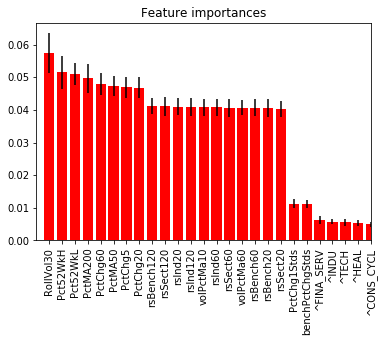

In [175]:
show_fi(clf1, X_train, 25)

In [534]:
print('Confussion Matrix\n', confusion_matrix(clf.predict(X_test), y_test, labels=fwd_ret_labels))

Confussion Matrix
 [[17098  2047   363   352   218]
 [ 1755 15847  2658   558   180]
 [   51  1595  6412  1339    57]
 [  781  1857  5004 23398  3253]
 [ 1638  2128  1755  5593 32988]]


In [535]:
print('Classificaton report\n', classification_report(clf.predict(X_test), y_test, target_names=fwd_ret_labels))

Classificaton report
               precision    recall  f1-score   support

        bear       0.80      0.85      0.83     20078
       short       0.90      0.75      0.82     44102
     neutral       0.75      0.68      0.71     34293
        long       0.40      0.68      0.50      9454
        bull       0.68      0.75      0.71     20998

   micro avg       0.74      0.74      0.74    128925
   macro avg       0.70      0.74      0.71    128925
weighted avg       0.77      0.74      0.75    128925



In [536]:
log_loss(y_test, clf.predict_proba(X_test))

0.945469193272936

#### Gridsearches

In [342]:
np.arange(10, X.shape[1], int(X.shape[1]*.25))

array([10, 36, 62, 88])

In [ ]:
%%time
# GridSearchCV for RandomForestClassifier
parameters = {
    'n_estimators': [10, 20, 40], 
    'max_features': np.arange(10, X.shape[1], int(X.shape[1]*.25)), 
    'random_state': np.arange(1, 10, 3)}

# parameters = {
#     'n_estimators': [80], 
#     'max_features': [16], 
#     'random_state': [4]}

clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train), clf.score(X_test, y_test))
print(clf.best_params_)

### Feature construction

In [162]:
%%time
df = get_symbol_pricing(ticker)
ft_df = px_mom_feats(df, ticker, stds, inv, incl_px, sec_windows, incl_name)
ft_df[y_col] = px_fwd_rets(
    df.close, ticker, pred_fwd_windows).mean(axis=1, skipna=False)

Loading file quote/csv/2019-03-08
Loading file summary-categories/assetProfile
CPU times: user 103 ms, sys: 2.58 ms, total: 106 ms
Wall time: 244 ms


In [1371]:
display_all(ft_df.describe(include='all'))

,PctChg1Stds,PctMA50,PctMA200,RollVol20,PctChg5,PctChg20,PctChg60,Pct52WkH,Pct52WkL,symbol,fwdReturn
count,"3,776.00","3,727.00","3,577.00","3,756.00","3,771.00","3,756.00","3,716.00","3,525.00","3,525.00",3776,"3,656.00"
unique,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan
top,nan,nan,nan,nan,nan,nan,nan,nan,nan,AAP,nan
freq,nan,nan,nan,nan,nan,nan,nan,nan,nan,3776,nan
mean,0.03,1.01,1.06,0.29,0.00,0.01,0.04,0.87,1.38,NaN,0.05
std,0.77,0.07,0.15,0.15,0.04,0.08,0.15,0.12,0.25,NaN,0.13
min,-10.00,0.64,0.60,0.08,-0.28,-0.38,-0.43,0.45,1.00,NaN,-0.35
25%,0.00,0.97,0.96,0.19,-0.02,-0.03,-0.06,0.80,1.18,NaN,-0.04
50%,0.00,1.02,1.06,0.25,0.00,0.01,0.05,0.90,1.34,NaN,0.05
75%,0.00,1.06,1.15,0.33,0.02,0.06,0.15,0.97,1.54,NaN,0.13


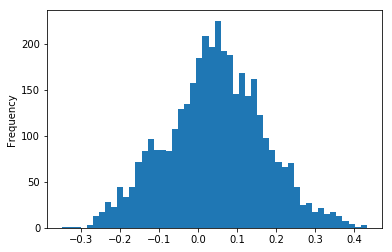

In [1372]:
Y = px_fwd_rets(df.close, ticker, pred_fwd_windows)
Y.mean(axis=1).plot.hist(bins=50)

In [1373]:
px_close[ticker].shape, px.close.shape

((3906,), (3775,))

In [1374]:
px_close[ticker].tail()

2019-03-01 00:00:00-05:00   160.62
2019-03-04 00:00:00-05:00   158.40
2019-03-05 00:00:00-05:00   157.31
2019-03-06 00:00:00-05:00   157.97
2019-03-07 00:00:00-05:00   154.10
Name: AAP, dtype: float64

In [1375]:
df = px_close[[ticker]].copy()
# df.set_index(df.index.astype(np.datetime64), inplace=True)
df.loc[:, 'weekday'] = df.index.weekday
df.weekday.unique()
df.tail(60)
df.groupby('weekday').describe()

AAP                                            
         count  mean   std   min   25%   50%    75%    max
weekday                                                   
0       707.00 81.62 49.28 22.50 39.25 65.97 127.24 200.38
1       773.00 81.81 49.40 22.64 39.03 65.99 126.79 198.70
2       777.00 81.62 49.36 22.91 38.93 66.13 126.46 199.34
3       763.00 81.76 49.24 22.40 39.30 66.18 126.68 200.34
4       756.00 81.89 49.32 22.10 39.31 66.21 127.50 198.72
5         0.00   nan   nan   nan   nan   nan    nan    nan

In [370]:
%%time
df = get_symbol_pricing(ticker)
co = px_mom_co_feats(
    df, indices_df, 
    [bench] + list(profile.loc[ticker, ['sector', 'industry']]))

CPU times: user 96 ms, sys: 3.36 ms, total: 99.3 ms
Wall time: 596 ms


In [1393]:
co.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3906 entries, 2004-03-08 00:00:00-05:00 to 2019-03-07 00:00:00-05:00
Data columns (total 13 columns):
rsBench20     3756 non-null float64
rsSect20      3756 non-null float64
rsInd20       3756 non-null float64
rsBench60     3716 non-null float64
rsSect60      3716 non-null float64
rsInd60       3716 non-null float64
rsBench120    3656 non-null float64
rsSect120     3656 non-null float64
rsInd120      3656 non-null float64
volPctMa10    3767 non-null float64
volPctMa60    3717 non-null float64
sector        3906 non-null object
industry      3906 non-null object
dtypes: float64(11), object(2)
memory usage: 427.2+ KB


### Date and minute based time analysis

In [1007]:
freq = '1d'

In [1008]:
# s1, s2 = '1810.HK', 'AAPL'
group_pricing = pd.DataFrame()
df1 = get_symbol_pricing(s1, freq, ['close'])
df2 = get_symbol_pricing(s2, freq, ['close'])
group_pricing = pd.DataFrame(df1)
# group_pricing.loc[:, s2] = df2
group_pricing = pd.concat([group_pricing, df2], axis=1)
group_pricing.describe()
# group_pricing

,close,close
count,164.00,"3,775.00"
mean,14.24,66.80
std,2.88,56.49
min,9.70,1.81
25%,12.19,16.67
50%,13.59,54.28
75%,16.51,106.82
max,21.55,232.07


In [850]:
path = config['pricing_path'].format(freq)
data_dict = json_load(path + json_ext.format(ticker))

tz = data_dict['meta']['exchangeTimezoneName']
df = build_px_struct(data_dict, freq)

adjClose = data_dict['indicators']['adjclose'][0] if 'adjclose' in  data_dict['indicators'] else 0
close = data_dict['indicators']['quote'][0]
data_dict.keys(), data_dict['indicators'].keys()

(dict_keys(['meta', 'timestamp', 'indicators']), dict_keys(['quote']))

In [916]:
df.index.date

array([datetime.date(2019, 2, 28), datetime.date(2019, 2, 28),
       datetime.date(2019, 2, 28), ..., datetime.date(2019, 3, 6),
       datetime.date(2019, 3, 6), datetime.date(2019, 3, 6)], dtype=object)

In [851]:
dates = pd.to_datetime(
        data_dict['timestamp'], 
        unit='s', infer_datetime_format=True)
# dates = dates.astype(f'datetime64[ns, {tz}]')
# dates.tz_convert('America/New_York')
# dates = dates.tz_localize('America/New_York')
dates.floor('d' if freq == '1d' else 'min')

DatetimeIndex(['2019-02-28 14:30:00', '2019-02-28 14:31:00',
               '2019-02-28 14:32:00', '2019-02-28 14:33:00',
               '2019-02-28 14:34:00', '2019-02-28 14:35:00',
               '2019-02-28 14:36:00', '2019-02-28 14:37:00',
               '2019-02-28 14:38:00', '2019-02-28 14:39:00',
               ...
               '2019-03-06 20:50:00', '2019-03-06 20:51:00',
               '2019-03-06 20:52:00', '2019-03-06 20:53:00',
               '2019-03-06 20:54:00', '2019-03-06 20:55:00',
               '2019-03-06 20:56:00', '2019-03-06 20:57:00',
               '2019-03-06 20:58:00', '2019-03-06 20:59:00'],
              dtype='datetime64[ns]', length=1950, freq=None)

In [829]:
df.tail(5)

,high,low,open,close,adjclose,volume
2019-03-06 20:55:00,174.72,174.60,174.66,174.71,0,"148,802.00"
2019-03-06 20:56:00,174.73,174.67,174.67,174.71,0,"37,980.00"
2019-03-06 20:57:00,174.72,174.65,174.71,174.65,0,"70,312.00"
2019-03-06 20:58:00,174.80,174.64,174.65,174.76,0,"105,856.00"
2019-03-06 20:59:00,174.82,174.46,174.74,174.51,0,"385,081.00"


In [1018]:
freq = '1d'

In [1019]:
%time px_close = get_mults_pricing(symbols_list[:10], freq);

Retrieved pricing for 0700.HK
Retrieved pricing for 1810.HK
Retrieved pricing for 3690.HK
Retrieved pricing for 9984.T
Retrieved pricing for A
Retrieved pricing for AAL
Retrieved pricing for AAN
Retrieved pricing for AAON
Retrieved pricing for AAP
Retrieved pricing for AAPL
CPU times: user 1.05 s, sys: 45.5 ms, total: 1.1 s
Wall time: 3.91 s


In [1022]:
# [px_close[x].dropna().tail() for x in px_close.columns]
px_close.describe()
# px_close.tail()

,0700.HK,0700.HK,1810.HK,3690.HK,9984.T,A,AAL,AAN,AAON,AAP,AAPL
count,"3,634.00","3,634.00",164.00,111.00,"3,743.00","3,775.00","3,382.00","3,775.00","1,258.00","3,775.00","3,775.00"
mean,94.03,94.03,14.24,54.89,"4,406.54",33.28,26.97,23.86,28.76,81.72,66.80
std,115.76,115.76,2.88,7.61,"2,785.93",15.49,17.32,10.35,6.93,49.29,56.49
min,0.68,0.68,9.70,41.20,650.00,8.90,1.76,9.33,16.97,22.10,1.81
25%,9.51,9.51,12.19,48.45,"2,148.00",22.63,9.12,14.67,22.29,39.16,16.67
50%,40.18,40.18,13.59,55.00,"2,960.00",27.83,30.26,23.71,28.15,66.07,54.28
75%,142.08,142.08,16.51,59.82,"7,127.50",40.84,42.34,29.12,35.06,126.80,106.82
max,474.60,474.60,21.55,72.65,"11,470.00",81.24,62.95,55.45,43.83,200.38,232.07


In [1023]:
f'Ticker: {ticker}'

'Ticker: AAPL'

In [1024]:
px = get_symbol_pricing(ticker, freq)
px.close.tail()

2019-02-28 00:00:00-05:00   173.15
2019-03-01 00:00:00-05:00   174.97
2019-03-04 00:00:00-05:00   175.85
2019-03-05 00:00:00-05:00   175.53
2019-03-06 00:00:00-05:00   174.52
Name: close, dtype: float64

### Old code

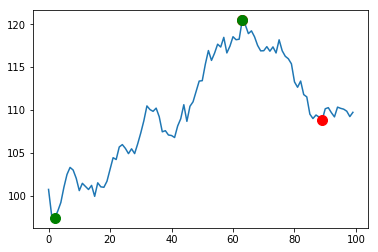

In [8]:
# Test cumulative drawdowns and pulls
n = 100
r_w = np.random.randn(n).cumsum() + 100
l_dd, h_dd, l_p, h_p = max_draw_pull(r_w)

plt.plot(r_w)
plt.plot(
    [l_dd, h_dd], 
    [r_w[l_dd], r_w[h_dd],], 
    'o', color='Red', markersize=10)
plt.plot(
    [l_p, h_p], 
    [r_w[l_p], r_w[h_p]], 
    'o', color='Green', markersize=10)

In [1103]:
# Retrieves historical pricing
secpx = get_symbol_pricing(symbol, freq)
secpx.set_index(secpx.index.astype(np.datetime64), inplace=True)

In [1110]:
fwd_ss_ret = lambda x, df, arr: df.loc[[y for y in arr[x-1] if y in df.index.tolist()]].mean()

In [1111]:
# seasonality analysis
ss_df = closepx.pct_change().resample('M').sum().to_frame()
ss_df['year'], ss_df['month'] = ss_df.index.year, ss_df.index.month
ss_df = ss_df.pivot_table(index='year', columns='month').mean()
ss_pos = [(x, (x+1) if not (x+1) // 12 else 0, 
     x+2 if not (x+2) // 12 else x - 10) for x in range(12)]

# [fwd_ss_ret(x+1, ss_df['close'], ss_pos) for x in range(12)] # test

In [1112]:
# apply seasonality, mean return of curr month plus next two
secpx['month'] = secpx.index.month
secpx['fwdSSRet'] = secpx.loc[:].month.apply(
    fwd_ss_ret, args=(ss_df['close'], ss_pos,))

In [ ]:
secpx.columns # all columns

In [ ]:
# normalized columns for ML training, still has outliers
ml_ds_cols = secpx.describe().loc['50%'][secpx.describe().loc['50%'] < 5].index.tolist()
ml_ds_cols

In [ ]:
# prepare ML dataset
ml_ds = secpx[ml_ds_cols].copy()

class_cols = ['fwdChg1w', 'fwdChg1m', 'fwdChg3m']
cut_range = [-1, -0.05, .0, .02, .09, 1.]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

for c in class_cols: ml_ds[c] = pd.cut(secpx[c], cut_range, labels=fwd_ret_labels)
ml_ds.info()

In [ ]:
# drop the predicting class with most nas
ml_ds.dropna(inplace=True)
ml_ds.info()

In [ ]:
ml_ds.hist(figsize=(15,15));

In [622]:
ml_ds.to_csv(csv_ext.format('co_price_mom_ds'), index=False)